2024-05-03 15:37:44.816335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-03 15:37:44.817508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-03 15:37:44.818771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

skier pauses on snow covered landscape


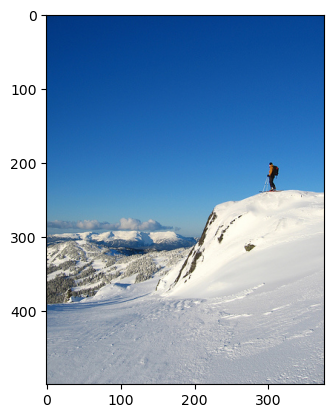

In [5]:
from sre_parse import Tokenizer
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
import matplotlib.pyplot as plt
from translate import Translator
from gtts import gTTS
import os
import warnings
warnings.filterwarnings('ignore')

def load_feature_extractor_model() -> Model:
    """
    Load a pre-trained VGG16 model, modified to remove the final classification layer.
    
    Returns:
    Model: The modified VGG16 model with output features from the penultimate layer.
    """
    base_model = VGG16()  # Load the base VGG16 model with weights trained on ImageNet
    feature_extractor_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    return feature_extractor_model

feature_model = load_feature_extractor_model()  # Instantiate the feature extraction model

def load_trained_captioning_model() -> Model:
    """
    Load a custom trained model for image captioning from a specified file path.
    
    Returns:
    Model: The trained image captioning model.
    """

    base_dir = os.getcwd()
    path_to_model = os.path.join(base_dir, 'working', 'mymodel.h5')
    captioning_model = load_model(path_to_model)
    return captioning_model

captioning_model = load_trained_captioning_model()  # Load the custom trained captioning model

# Load the tokenizer
base_dir = os.getcwd()
tokenizer_path = os.path.join(base_dir, 'tokenizer.pkl')
with open(tokenizer_path, 'rb') as file:
    caption_tokenizer = pickle.load(file)

# Path to the image to be processed

image_path = os.path.join(base_dir, 'TestImages', 'NewTest03.jpg')


# Load and preprocess the image
def preprocess_image(image_path: str) -> np.ndarray:
    """
    Load an image from the path and preprocess it for feature extraction.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    np.ndarray: The preprocessed image suitable for input into the VGG16 model.
    """
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))
    return preprocess_input(img_array)

processed_image = preprocess_image(image_path)

# Extract features using the loaded VGG16 model
image_features = feature_model.predict(processed_image, verbose=0)

# Define maximum length of any caption
max_length = 38

def predict_image_caption(model: Model, features: np.ndarray, tokenizer: Tokenizer, max_len: int) -> str:
    """
    Generate a caption for an image given its features.

    Parameters:
    model (Model): The trained captioning model.
    features (np.ndarray): Extracted features of the image.
    tokenizer (Tokenizer): Tokenizer for processing captions.
    max_len (int): Maximum length of the caption.

    Returns:
    str: Generated caption for the image.
    """
    caption = "startseq"
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        padded_sequence = pad_sequences([sequence], maxlen=max_len)
        prediction = model.predict([features, padded_sequence], verbose=0)
        predicted_index = np.argmax(prediction)
        predicted_word = next((word for word, idx in tokenizer.word_index.items() if idx == predicted_index), None)
        if predicted_word is None or predicted_word == "endseq":
            break
        caption += " " + predicted_word
    return caption

# Generate a caption for the loaded image
caption = predict_image_caption(captioning_model, image_features, caption_tokenizer, max_length)

# Load and display the image
display_image = Image.open(image_path)

# Clean up the generated caption
formatted_caption = caption.replace("startseq", "").replace("endseq", "").strip()
print(formatted_caption)
plt.imshow(display_image)
plt.show()


In [8]:
def translate_text(text: str, target_language: str) -> str:
    """
    Translates a given text into the specified target language using the Translator class from the translate package.

    Parameters:
    text (str): The text to be translated.
    target_language (str): The language code for the target language (e.g., 'fr' for French).

    Returns:
    str: The translated text.
    """
    try:
        # Initialize the translator with the target language
        translator = Translator(to_lang=target_language)
        # Perform the translation
        translated_text = translator.translate(text)
        return translated_text
    except Exception as e:
        # Handle potential errors during the translation process
        print(f"An error occurred during translation: {e}")
        return ""


# Specify the target language for translation
target_language = "fr"

# Translate the caption and print the result
translated_caption = translate_text(formatted_caption, target_language)
print(translated_caption)


le skieur s'arrête sur un paysage enneigé


In [11]:
def text_to_speech(text: str, language: str, output_file_path: str, speed: bool = False) -> None:
    """
    Converts text to speech and saves the audio to a file using Google's Text-to-Speech service.

    Parameters:
    text (str): The text to be converted into speech.
    language (str): The language code for the speech (e.g., 'en' for English, 'fr' for French).
    output_file_path (str): The path where the audio file will be saved.
    speed (bool): The speed of the speech; 'True' for slow, 'False' for normal speed.

    Returns:
    None: The function saves the audio file to the specified path and does not return anything.
    """
    try:
        # Create a gTTS object with the specified parameters
        tts = gTTS(text=text, lang=language, slow=speed)
        # Save the audio file in the specified location
        tts.save(output_file_path)
        print(f"Audio saved successfully at {output_file_path}")
    except Exception as e:
        # Handle exceptions that may occur during text to speech conversion
        print(f"Failed to convert text to speech: {e}")

# Example usage of the function
translated_text = "Ceci est un exemple de texte traduit."

output_audio_path = os.path.join(base_dir, 'AudioOutputs', 'Audio14.mp3')
#output_audio_path = "/Users/kirankumar/Documents/Studies/Spring2024/NLP/Project/image-caption-generator/AudioOutputs/Audio14.mp3"
language_code = "fr"

# Convert the translated text to speech and save it as an MP3 file
text_to_speech(formatted_caption, language_code, output_audio_path)


Audio saved successfully at /Users/kirankumar/Documents/Studies/Spring2024/NLP/Project/NLPProject/image_captioning/AudioOutputs/Audio14.mp3
